***init: 21-out-2021***

_______

## Summary


#### [The problem](#0)

#### [1. Prediction](#2)

#### [2. Next steps](#3)

_______

<a id='0'></a>

# The Problem


### Google Brain - Ventilator Pressure Prediction

> Current simulators are trained as an ensemble, where each model simulates a single lung setting. However, lungs and their attributes form a continuous space, so a parametric approach must be explored that would consider the differences in patient lungs. 


> In this competition, you’ll simulate a ventilator connected to a sedated patient's lung. The best submissions will take lung attributes compliance and resistance into account.


#### Timeline:

* September 22, 2021 - Start Date.

* October 27, 2021 - Entry Deadline. You must accept the competition rules before this date in order to compete.

* October 27, 2021 - Team Merger Deadline. This is the last day participants may join or merge teams.

* November 3, 2021 - Final Submission Deadline.


https://www.kaggle.com/c/ventilator-pressure-prediction/overview


_________

### Refs:

ensemble-folds-with-median-0-153.ipynb



## Data description

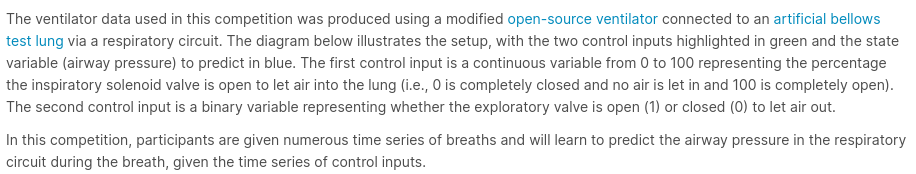

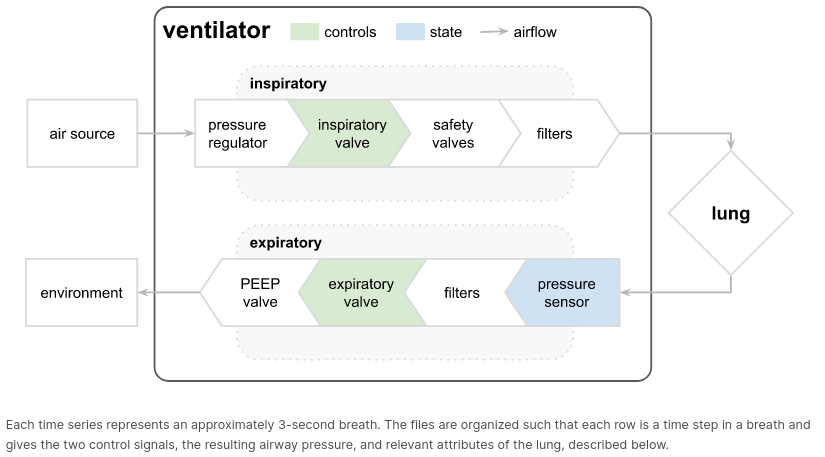

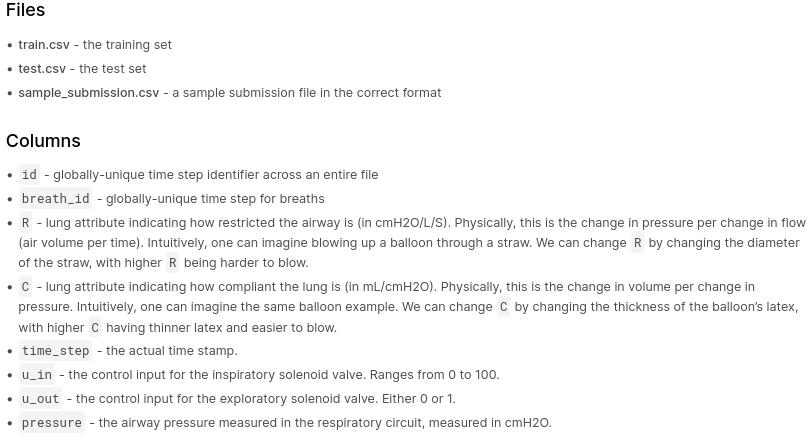

https://www.kaggle.com/c/ventilator-pressure-prediction/data

### Links:
#### 1. Open-source ventilator (Software + Hardware): https://www.peoplesvent.org/en/latest/
Written entirely in Python 3.7

#### 2. Artificial bellows test lung via a respiratory circuit.: https://www.ingmarmed.com/product/quicklung/
Ventilator performance verification: combine with any flow/volume/ pressure analyzer for a complete ventilator testing system

#### 3. Open Source Ventilator Project System Integration Test:
https://www.youtube.com/watch?v=KhgUCOhOCNM

_________

### <font color='green'>Hint from video of link 3:</font>

<u>Some usual configurations:</u>

RespRate: 10, 15, 30*

I:E Ratio 1:2; 1:3; 1:4

I:E Ratio 2:1; 1:1; 1:2

_________

<a id='2'></a>

# 1. PREDICTION

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import time
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler

#import optuna # for new tests

train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
train.head(2)

### Set GPU (or TPU)

In [ ]:
'''
# detect and init the tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
'''

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print(tf.test.gpu_device_name())
    except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)


## Add New Features

In [ ]:
init = time.time()

def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

train = add_features(train)
test = add_features(test)

print('Elapsed time (s): ', time.time() - init)

In [ ]:
train.describe()

### Correlation Matrix

In [ ]:
init = time.time()
train_corr_mat = train.dropna(how='any').corr()
print('Elapsed time (s): ', time.time() - init)

#### Drop NaN of Coorelation matrix

In [ ]:
train_corr_mat = train.drop(['breath_id__u_out__max'], axis=1).corr() # the breath_id__u_out__max corr has NaN
#train_corr_mat

In [ ]:
g = sns.clustermap(train_corr_mat.sort_values(by='pressure'), figsize=(15, 10), cmap='Greens',
                   vmin=-1, vmax=1, annot=False, row_cluster=False,
                   dendrogram_ratio=(.05, .2), cbar_pos=(0, 0.4, 0.01, 0.31))

### Note:

#### Maybe we can consider review the new features based on the original matrix correlation of training set and the above.

## Define target and Scale dataset

In [ ]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id'], axis=1)

RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

## Define Model LSTM or Bidirectional LSTM

### Split dataset

In [ ]:
#idx_len = round(0.80*len(train))
idx_len = round(0.80*len(train))
X_train, X_valid = train[0:idx_len], train[idx_len:]
y_train, y_valid = targets[0:idx_len], targets[idx_len:]

### Define some hyperparameters

In [ ]:
#EPOCH = 300
#BATCH_SIZE = 128
### => score ~ 0.18

#EPOCH = 500
#BATCH_SIZE = 64 
### => score ~ 0.30

EPOCH = 500
BATCH_SIZE = 256

lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min", restore_best_weights=True)

### Training model

In [ ]:
init = time.time()

'''
with tpu_strategy.scope():
    
    model = keras.models.Sequential([
    keras.layers.Input(shape=train.shape[-2:]),    
    keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.Dense(1),
])

    model.compile(optimizer="adam", loss="mae")

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                        epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es])
'''

    
model = keras.models.Sequential([
keras.layers.Input(shape=train.shape[-2:]),    
keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
keras.layers.Dense(64, activation='selu'),
keras.layers.Dense(1),
])

model.compile(optimizer="adam", loss="mae")

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                    epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es])

print('Elapsed time (min): ', (time.time() - init)/60)

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

### Save trained model

In [ ]:
model.save('bidirectional_lstm_model[500epochs_gpu_bacth256].h5')

### Load trainde model

In [ ]:
#model_cpu = tf.keras.models.load_model('lstm_model.h5')

### Model summary 

In [ ]:
model.summary()
#model_cpu.summary()

## Prediction

In [ ]:
#test_pred = model_cpu.predict(test, batch_size=BATCH_SIZE)
test_pred = model.predict(test, batch_size=BATCH_SIZE)

## Submission

In [ ]:
# save for submission
submission['pressure'] = test_pred.squeeze().reshape(-1, 1).squeeze()
submission.to_csv('bidirectional_lstm_model[500epochs_gpu_bacth256].csv', index=False)

In [ ]:
submission.head()

________

<a id='3'></a>

# 2. Next steps:

* Create a hyperparameter search and use Optuna to automate hyperparameter search.


* Review actual features and add new features based on correlation matrix.


* Test new models and architeture of LSTM for GPUs.



### References:

* i-am-groot-tpu-war.ipynb (https://www.kaggle.com/shivansh002/i-am-groot-tpu-war)

* deep-learning-starter-simple-lstm.ipynb (https://www.kaggle.com/theoviel/deep-learning-starter-simple-lstm)



* ensemble-folds-with-median-0-153.ipynb (https://www.kaggle.com/manabendrarout/single-bi-lstm-model-pressure-predict-gpu-infer)



* ensemble-folds-with-median-0-153.ipynb (https://www.kaggle.com/cdeotte/ensemble-folds-with-median-0-153)



* finetune-of-tensorflow-bidirectional-lstm.ipynb (https://www.kaggle.com/tenffe/finetune-of-tensorflow-bidirectional-lstm)